In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import math
import itertools
from keras import models, layers, optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, SeparableConv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ReduceLROnPlateau
from keras import backend as K
from sklearn.metrics import classification_report, recall_score, precision_score, confusion_matrix, f1_score, accuracy_score
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from keras.applications.resnet50 import ResNet50


In [2]:
data_dir = '/kaggle/input/lc2500/lung_image_sets'


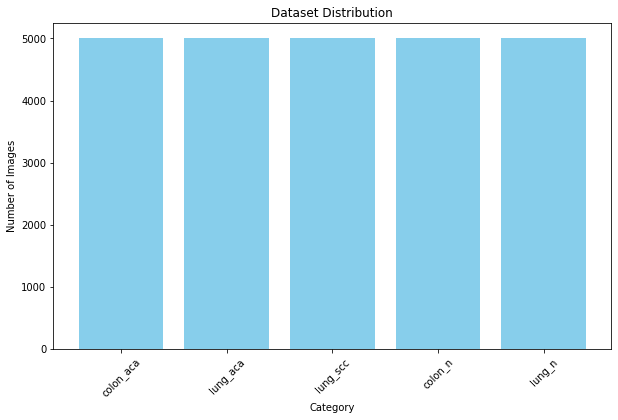

In [3]:
def visualize_data_distribution(data_dir):
    categories = os.listdir(data_dir)
    category_counts = {category: len(os.listdir(os.path.join(data_dir, category))) for category in categories}
    
    plt.figure(figsize=(10, 6))
    plt.bar(category_counts.keys(), category_counts.values(), color='skyblue')
    plt.title('Dataset Distribution')
    plt.xlabel('Category')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45)
    plt.show()

visualize_data_distribution(data_dir)


In [4]:
train_datagen_resnet = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        validation_split=0.2)

train_generator_resnet = train_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        subset='training'
        )

Found 20000 images belonging to 5 classes.


In [5]:
val_datagen_resnet = ImageDataGenerator(rescale=1./255)

val_generator_resnet = train_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical',
        subset='validation'
        )

Found 5000 images belonging to 5 classes.


In [6]:
test_datagen_resnet = ImageDataGenerator(rescale=1./255)

test_generator_resnet = test_datagen_resnet.flow_from_directory(
        '/kaggle/input/lc2500/lung_image_sets',
        target_size=(224, 224),
        batch_size=128,
        class_mode='categorical')

Found 25000 images belonging to 5 classes.


In [7]:
def visualize_sample_images(generator):
    class_names = list(generator.class_indices.keys())
    plt.figure(figsize=(15, 10))
    
    for i, class_name in enumerate(class_names):
        folder_path = os.path.join(generator.directory, class_name)
        image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
        
        img = load_img(image_path, target_size=(224, 224))
        img_array = img_to_array(img)
        img_array = img_array / 255.0
        
        plt.subplot(1, len(class_names), i + 1)
        plt.imshow(img_array)
        plt.title(class_name)
        plt.axis('off')
    
    plt.show()

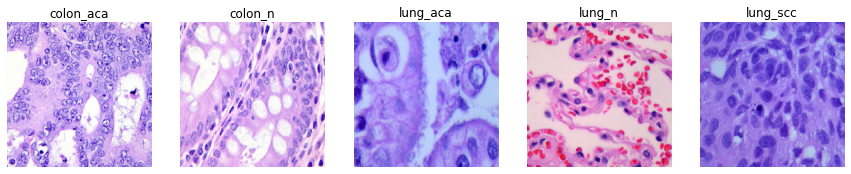

In [8]:

visualize_sample_images(train_generator_resnet)

In [9]:
from keras.applications.resnet50 import ResNet50

In [10]:
rn50=ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             weights='imagenet')

for layer in rn50.layers:
    layer.trainable=False

94773248/94765736 [==============================] - 0s 0us/step


In [11]:
last_layer=rn50.layers[-1]
last_output = last_layer.output

In [ ]:
x=layers.GlobalAveragePooling2D()(last_output)
x=layers.Dense(5,activation='softmax')(x)
resnet50=keras.Model(rn50.input,x)

In [ ]:
resnet50.summary()

In [ ]:
resnet50.compile(optimizer='adam',
              loss='categorical_crossentropy',
               metrics=['accuracy',Precision(),Recall()])

In [ ]:
history_resnet=resnet50.fit_generator(train_generator_resnet,validation_data=val_generator_resnet,epochs=60,verbose=2)

In [ ]:
plt.plot(history_resnet.history['loss'])
plt.plot(history_resnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet.history['accuracy'])
plt.plot(history_resnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet.history['precision_1'])
plt.plot(history_resnet.history['val_precision_1'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
plt.plot(history_resnet.history['recall_1'])
plt.plot(history_resnet.history['val_recall_1'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
val_metrics = resnet50.evaluate(val_generator_resnet)
print(f'Validation Loss: {val_metrics[0]}')
print(f'Validation Accuracy: {val_metrics[1]}')
print(f'Validation Precision: {val_metrics[2]}')
print(f'Validation Recall: {val_metrics[3]}')


In [ ]:
test_metrics = resnet50.evaluate(test_generator_resnet)
print(f'Testing Loss: {test_metrics[0]}')
print(f'Testing Accuracy: {test_metrics[1]}')
print(f'Testing Precision: {test_metrics[2]}')
print(f'Testing Recall: {test_metrics[3]}')


In [ ]:
train_metrics = resnet50.evaluate(train_generator_resnet)
print(f'Training Loss: {train_metrics[0]}')
print(f'Training Accuracy: {train_metrics[1]}')
print(f'Training Precision: {train_metrics[2]}')
print(f'Training Recall: {train_metrics[3]}')

In [ ]:
Y_pred = resnet50.predict(test_generator_resnet)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator_resnet.classes

print('Confusion Matrix')
cm = confusion_matrix(y_true, y_pred)
print(cm)

print('Classification Report')
target_names = list(test_generator_resnet.class_indices.keys())
print(classification_report(y_true, y_pred, target_names=target_names))


In [ ]:
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(target_names))
plt.xticks(tick_marks, target_names, rotation=45)
plt.yticks(tick_marks, target_names)

fmt = 'd'
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.show()

In [ ]:
resnet50.save('resnet50.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('/kaggle/working/resnet50.h5',compile=False)
print("Model loaded successfully.")



In [ ]:
def predict_image(image_path, model):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0

    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)
    
    class_names = list(train_generator_resnet.class_indices.keys())
    predicted_class_name = class_names[predicted_class[0]]
    
    plt.imshow(img_array[0])
    plt.title(f'Predicted: {predicted_class_name}')
    plt.axis('off')
    plt.show()


In [ ]:
sample_image_path = '/kaggle/input/lc2500/lung_image_sets/colon_aca/colonca1.jpeg'  
predict_image(sample_image_path, loaded_model)


In [ ]:
sample_image_path = '/kaggle/input/lc2500/lung_image_sets/lung_n/lungn1.jpeg'  
predict_image(sample_image_path, loaded_model)